In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19,VGG16, ResNet50
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, classification_report
import argparse

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
def equalize(img):
    #print(type(img), img.shape)
    img1=np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img1)
    img = cv2.equalizeHist(img)
    img = tf.expand_dims(img, axis=-1)
    img = np.array(img)
    img = img.astype(np.float64)
    #print(type(img), img.shape)
    return img

In [20]:
data_dir = ''
train_path = 'Train/'
test_path = 'Test/'
height = 32
width = 32


In [21]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [22]:
batch_size = 150
seed = 42


In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   preprocessing_function=equalize)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='grayscale',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2,
                                   preprocessing_function=equalize)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='grayscale',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [24]:
train_labels= train_dataset.labels
test_labels= test_dataset.labels

In [25]:
list_set = set(train_labels)
unique_list = (list(list_set))

print(unique_list)
unique_list.append(43)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [27]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv('Test.csv')

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img,cv2.IMREAD_GRAYSCALE)
        image_fromarray = Image.fromarray(image, 'L')
        resize_image = image_fromarray.resize((height, width))
        resize_image = np.array(resize_image)
        resize_image = equalize(resize_image)
        data.append(resize_image)
    except  Exception as e:
        print("Error in " + img)
        print(e)
X_test = np.array(data)
X_test = X_test/255

# LeNet Model

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("LeNet.keras", monitor="val_loss",save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=60, kernel_size=(5,5), activation='relu', input_shape=(height,width,1)),
    keras.layers.Conv2D(filters=60, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [31]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)        │      1,560 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)        │     90,060 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 12, 12, 60)        │        240 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)        │     16,230 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)          │      8,130 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 4, 4, 30)          │        120 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 480)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 500)               │    240,500 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 500)               │      2,000 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 500)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 43)                │     21,543 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 380,383 (1.45 MB)

 Trainable params: 379,203 (1.45 MB)

 Non-trainable params: 1,180 (4.61 KB)

In [23]:
alpha=0.01
epochs=20
optim = keras.optimizers.Adam(learning_rate=alpha)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [24]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset),
                    callbacks=callbacks)


Epoch 1/20

210/210 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.8443
Epoch 1: val_loss improved from inf to 0.92879, saving model to LeNet.h5
210/210 [==============================] - 66s 303ms/step - loss: 0.5711 - accuracy: 0.8443 - val_loss: 0.9288 - val_accuracy: 0.8076
Epoch 2/20


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9507
Epoch 2: val_loss improved from 0.92879 to 0.30401, saving model to LeNet.h5
210/210 [==============================] - 61s 289ms/step - loss: 0.1613 - accuracy: 0.9507 - val_loss: 0.3040 - val_accuracy: 0.9288
Epoch 3/20
210/210 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9645
Epoch 3: val_loss did not improve from 0.30401
210/210 [==============================] - 62s 294ms/step - loss: 0.1172 - accuracy: 0.9645 - val_loss: 0.5895 - val_accuracy: 0.8968
Epoch 4/20
210/210 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9735
Epoch 4: val_loss did not improve from 0.30401
210/210 [==============================] - 62s 296ms/step - loss: 0.0857 - accuracy: 0.9735 - val_loss: 0.4208 - val_accuracy: 0.9070
Epoch 5/20
210/210 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9785
Epoch 5: val_loss improved from 0.30401 to 0.18037, sa

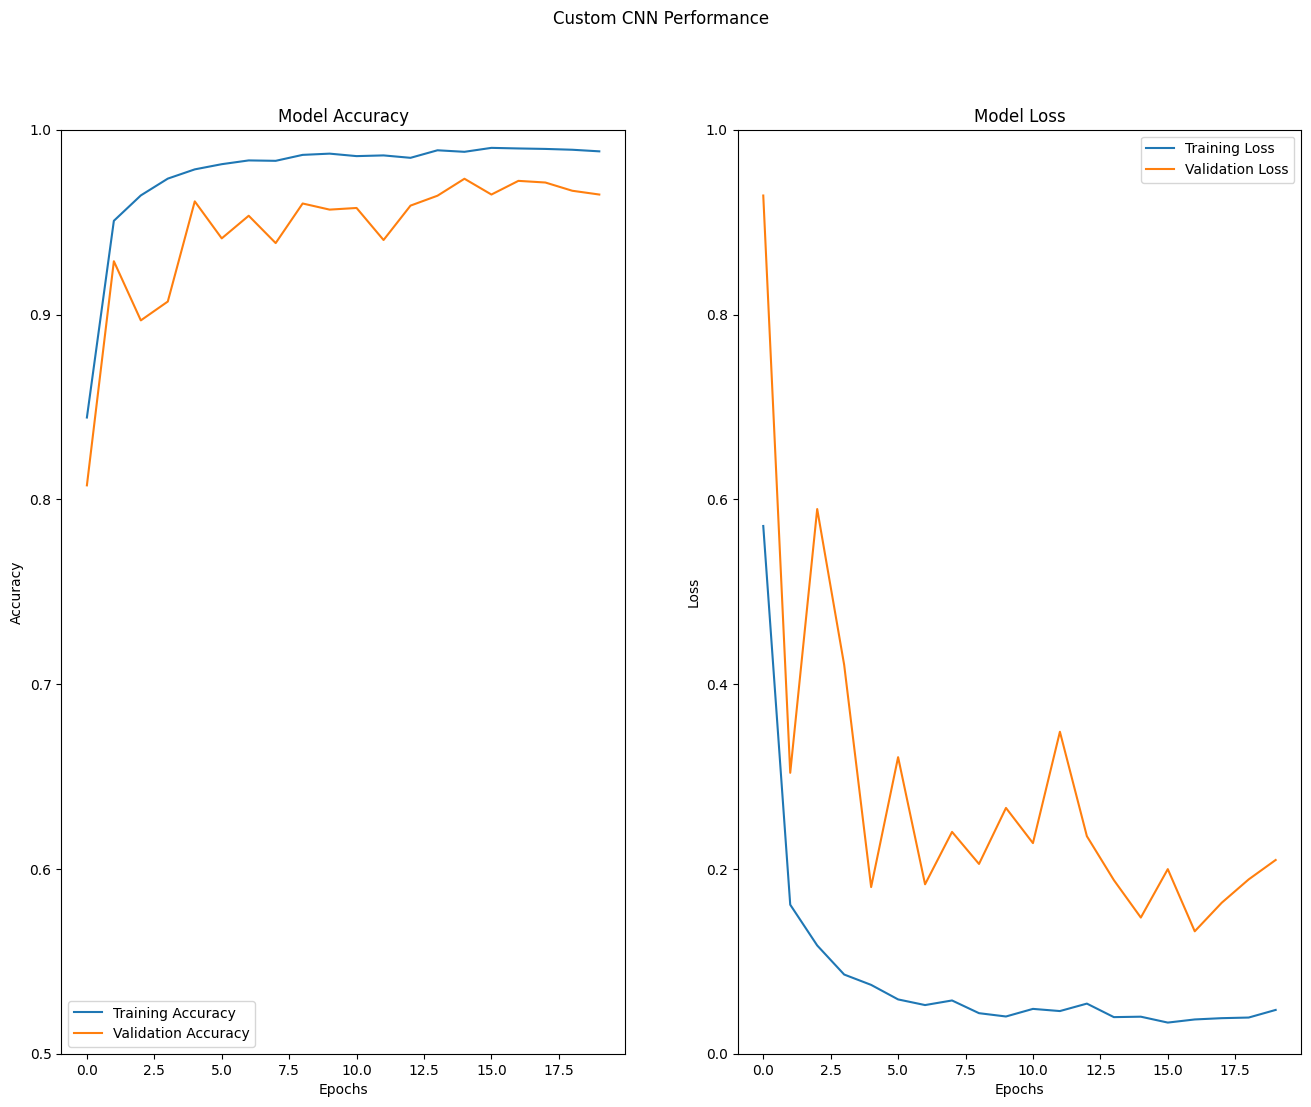

<Figure size 1000x700 with 0 Axes>

In [25]:
from sklearn.metrics import classification_report

fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('Custom CNN Performance')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
savedModel=load_model('LeNet.keras')

In [81]:
from sklearn.metrics import accuracy_score
pred = savedModel.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)
print('===========================================================================')
print(classification_report(test_labels, pred))

395/395 [==============================] - 6s 14ms/step
Test Data accuracy:  96.26286619160729
              precision    recall  f1-score   support

           0       0.85      0.95      0.90        60
           1       0.94      0.99      0.96       720
           2       0.98      0.99      0.98       750
           3       0.87      0.98      0.92       450
           4       0.97      0.99      0.98       660
           5       0.96      0.85      0.90       630
           6       0.97      0.92      0.94       150
           7       0.98      0.95      0.97       450
           8       0.95      0.95      0.95       450
           9       0.97      1.00      0.98       480
          10       0.99      0.99      0.99       660
          11       0.97      0.98      0.97       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       0.98      1.00      0.99       270
          15       0.92      0.98      0

# VGG16 Model

In [55]:
vgg_model = tf.keras.Sequential([VGG16(weights=None, include_top=False, input_shape=(height,width,1)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14713536  
                                                                 
 batch_normalization_4 (Bat  (None, 1, 1, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 43)                22059     
                                                                 
Total params: 15000299 (57.22 MB)
Trainable params: 14999275 (57.22 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [56]:
alpha=0.001
epochs=20
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [57]:
checkpoint = ModelCheckpoint("VGG16.keras", monitor="val_loss",save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [58]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        callbacks=callbacks)

Epoch 1/20
210/210 [==============================] - ETA: 0s - loss: 2.1574 - accuracy: 0.3439
Epoch 1: val_loss improved from inf to 6.15105, saving model to VGG16.h5
210/210 [==============================] - 324s 2s/step - loss: 2.1574 - accuracy: 0.3439 - val_loss: 6.1511 - val_accuracy: 0.1004
Epoch 2/20


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.7583
Epoch 2: val_loss improved from 6.15105 to 4.27825, saving model to VGG16.h5
210/210 [==============================] - 305s 1s/step - loss: 0.7859 - accuracy: 0.7583 - val_loss: 4.2782 - val_accuracy: 0.1697
Epoch 3/20
210/210 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8993
Epoch 3: val_loss improved from 4.27825 to 1.87252, saving model to VGG16.h5
210/210 [==============================] - 300s 1s/step - loss: 0.3526 - accuracy: 0.8993 - val_loss: 1.8725 - val_accuracy: 0.5205
Epoch 4/20
210/210 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9508
Epoch 4: val_loss improved from 1.87252 to 0.98824, saving model to VGG16.h5
210/210 [==============================] - 280s 1s/step - loss: 0.1835 - accuracy: 0.9508 - val_loss: 0.9882 - val_accuracy: 0.7142
Epoch 5/20
210/210 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9667


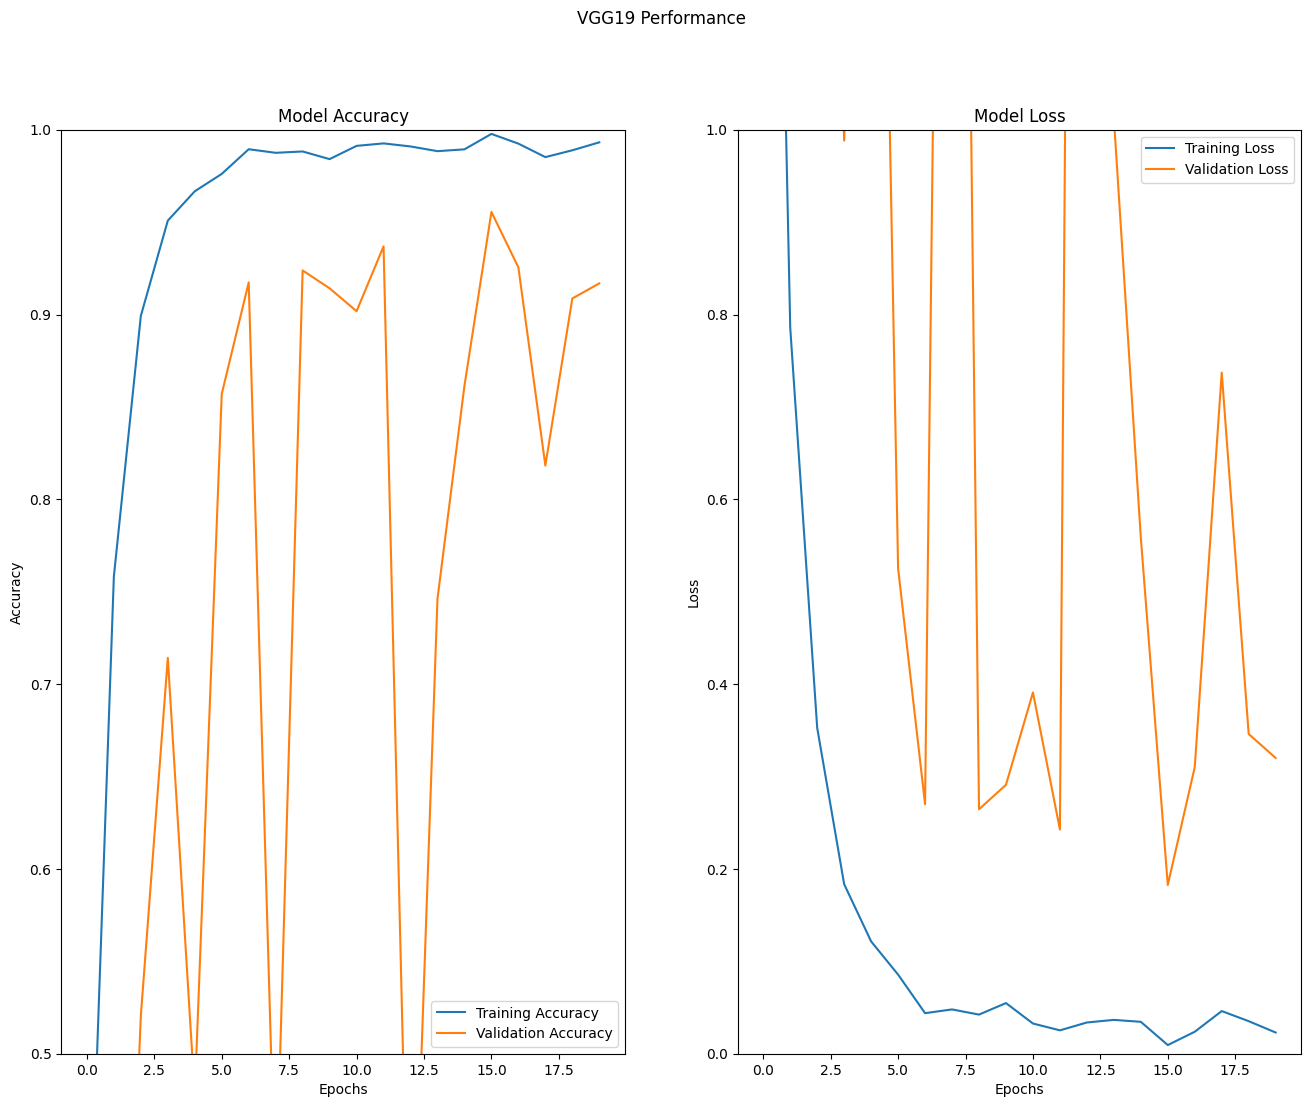

<Figure size 1000x700 with 0 Axes>

In [59]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

In [87]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
savedModel=load_model('VGG16.keras')
pred = savedModel.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)
print('===========================================================================')
print(classification_report(test_labels, pred))

395/395 [==============================] - 33s 84ms/step
Test Data accuracy:  94.26761678543151
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.98      0.98      0.98       720
           2       0.96      0.99      0.98       750
           3       0.97      0.88      0.93       450
           4       0.99      0.98      0.98       660
           5       0.91      0.97      0.94       630
           6       0.99      0.85      0.91       150
           7       1.00      0.96      0.98       450
           8       0.96      0.91      0.93       450
           9       0.95      1.00      0.97       480
          10       1.00      0.95      0.97       660
          11       0.88      0.98      0.93       420
          12       0.98      0.97      0.97       690
          13       0.97      1.00      0.98       720
          14       0.96      1.00      0.98       270
          15       0.80      0.80      

# VGG19 Model

In [63]:
vgg_model = tf.keras.Sequential([VGG19(weights=None, include_top=False, input_shape=(height,width,1)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20023232  
                                                                 
 batch_normalization_5 (Bat  (None, 1, 1, 512)         2048      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20309995 (77.48 MB)
Trainable params: 20308971 (77.47 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [64]:
alpha=0.001
epochs=20
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [66]:
checkpoint = ModelCheckpoint("VGG19.keras", monitor="val_loss",save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [67]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        callbacks=callbacks)

Epoch 1/20
210/210 [==============================] - ETA: 0s - loss: 2.5237 - accuracy: 0.2176
Epoch 1: val_loss improved from inf to 9.28628, saving model to VGG19.h5


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 381s 2s/step - loss: 2.5237 - accuracy: 0.2176 - val_loss: 9.2863 - val_accuracy: 0.0582
Epoch 2/20
210/210 [==============================] - ETA: 0s - loss: 1.4258 - accuracy: 0.5437
Epoch 2: val_loss did not improve from 9.28628
210/210 [==============================] - 372s 2s/step - loss: 1.4258 - accuracy: 0.5437 - val_loss: 10.9062 - val_accuracy: 0.0594
Epoch 3/20
210/210 [==============================] - ETA: 0s - loss: 0.9294 - accuracy: 0.7097
Epoch 3: val_loss improved from 9.28628 to 9.09974, saving model to VGG19.h5
210/210 [==============================] - 366s 2s/step - loss: 0.9294 - accuracy: 0.7097 - val_loss: 9.0997 - val_accuracy: 0.0925
Epoch 4/20
210/210 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7718
Epoch 4: val_loss did not improve from 9.09974
210/210 [==============================] - 355s 2s/step - loss: 0.7017 - accuracy: 0.7718 - val_loss: 12.3680 - val_accuracy: 0.0615
Epoch 5/20


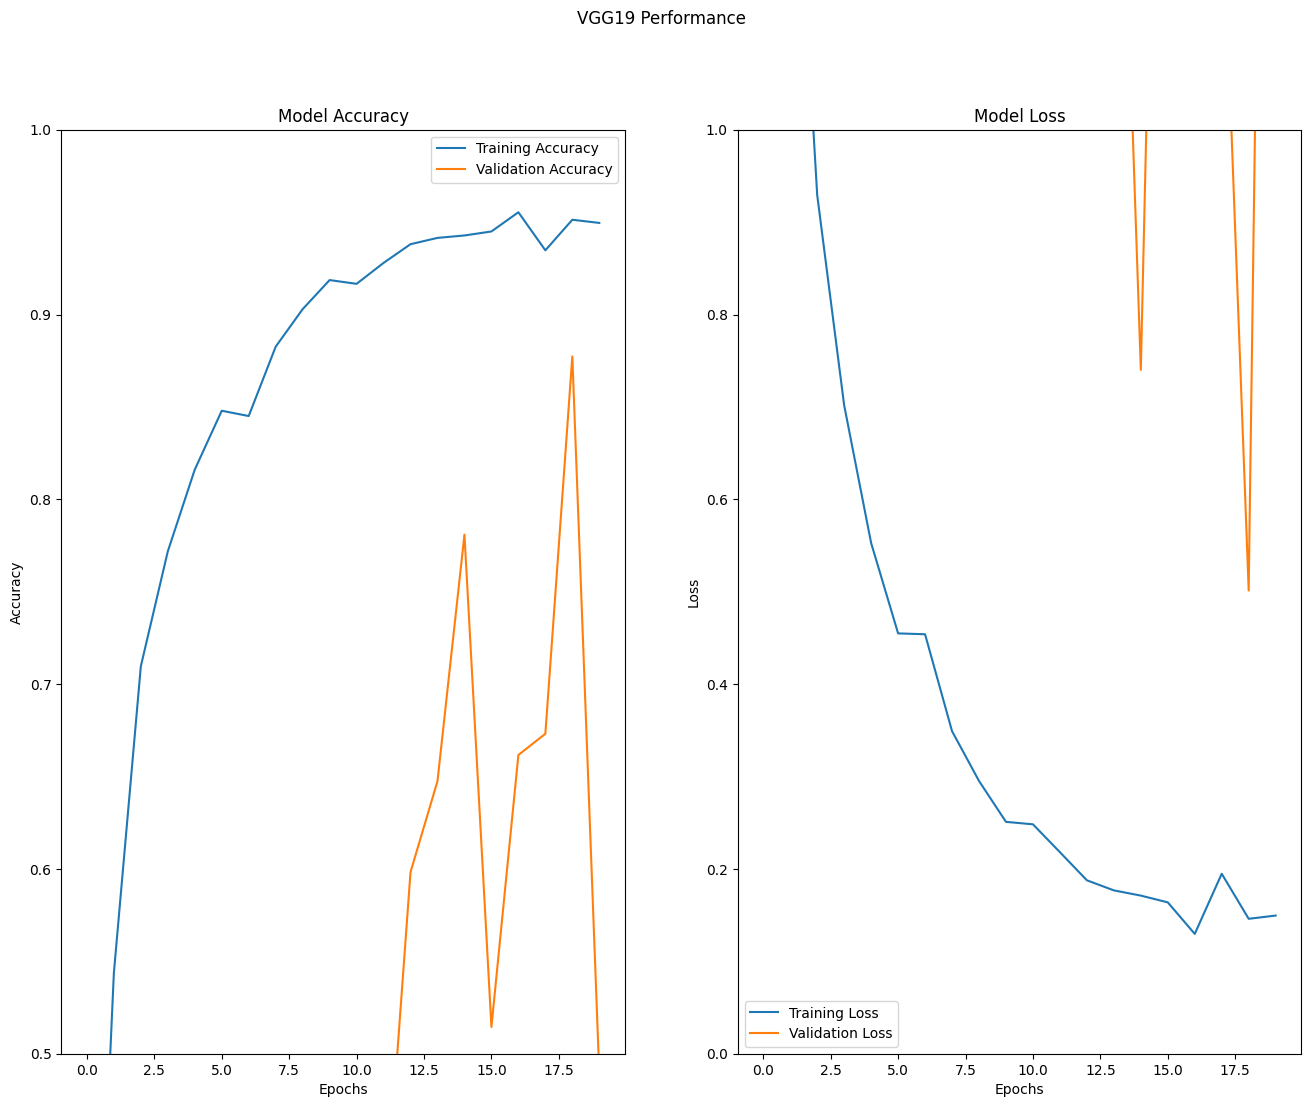

<Figure size 1000x700 with 0 Axes>

In [68]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

In [89]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
savedModel=load_model('VGG19.keras')
pred = savedModel.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)
print('===========================================================================')
print(classification_report(test_labels, pred))

395/395 [==============================] - 43s 109ms/step
Test Data accuracy:  85.61361836896279
              precision    recall  f1-score   support

           0       0.61      0.70      0.65        60
           1       0.95      0.94      0.95       720
           2       0.92      0.97      0.95       750
           3       0.94      0.80      0.86       450
           4       0.88      0.94      0.91       660
           5       0.91      0.93      0.92       630
           6       0.85      0.67      0.75       150
           7       0.97      0.94      0.95       450
           8       0.95      0.85      0.90       450
           9       1.00      0.96      0.98       480
          10       0.98      0.92      0.95       660
          11       0.90      0.93      0.91       420
          12       1.00      0.90      0.95       690
          13       0.97      0.99      0.98       720
          14       0.91      0.94      0.92       270
          15       0.74      0.66     

# ResNet50 Model

In [46]:
resnet_model = tf.keras.Sequential([ResNet50(weights=None, include_top=False, input_shape=(height,width,1)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 batch_normalization_3 (Bat  (None, 1, 1, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                                 
Total params: 24660779 (94.07 MB)
Trainable params: 24603563 (93.86 MB)
Non-trainable params: 57216 (223.50 KB)
________

In [47]:
alpha=0.001
epochs=20
optim = keras.optimizers.Adam(learning_rate=alpha)
resnet_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [48]:
checkpoint = ModelCheckpoint("ResNet50.keras", monitor="val_loss",save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [49]:
resnet_history = resnet_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset),
                        callbacks=callbacks)

Epoch 1/20
210/210 [==============================] - ETA: 0s - loss: 1.3111 - accuracy: 0.6210
Epoch 1: val_loss improved from inf to 6.00723, saving model to ResNet50.h5


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 297s 1s/step - loss: 1.3111 - accuracy: 0.6210 - val_loss: 6.0072 - val_accuracy: 0.0537
Epoch 2/20
210/210 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.9012
Epoch 2: val_loss improved from 6.00723 to 3.47602, saving model to ResNet50.h5
210/210 [==============================] - 300s 1s/step - loss: 0.3261 - accuracy: 0.9012 - val_loss: 3.4760 - val_accuracy: 0.2514
Epoch 3/20
210/210 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9482
Epoch 3: val_loss improved from 3.47602 to 0.63238, saving model to ResNet50.h5
210/210 [==============================] - 313s 1s/step - loss: 0.1727 - accuracy: 0.9482 - val_loss: 0.6324 - val_accuracy: 0.8192
Epoch 4/20
210/210 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9760
Epoch 4: val_loss did not improve from 0.63238
210/210 [==============================] - 309s 1s/step - loss: 0.0794 - accuracy: 0.9760 - val_loss: 0.6557 

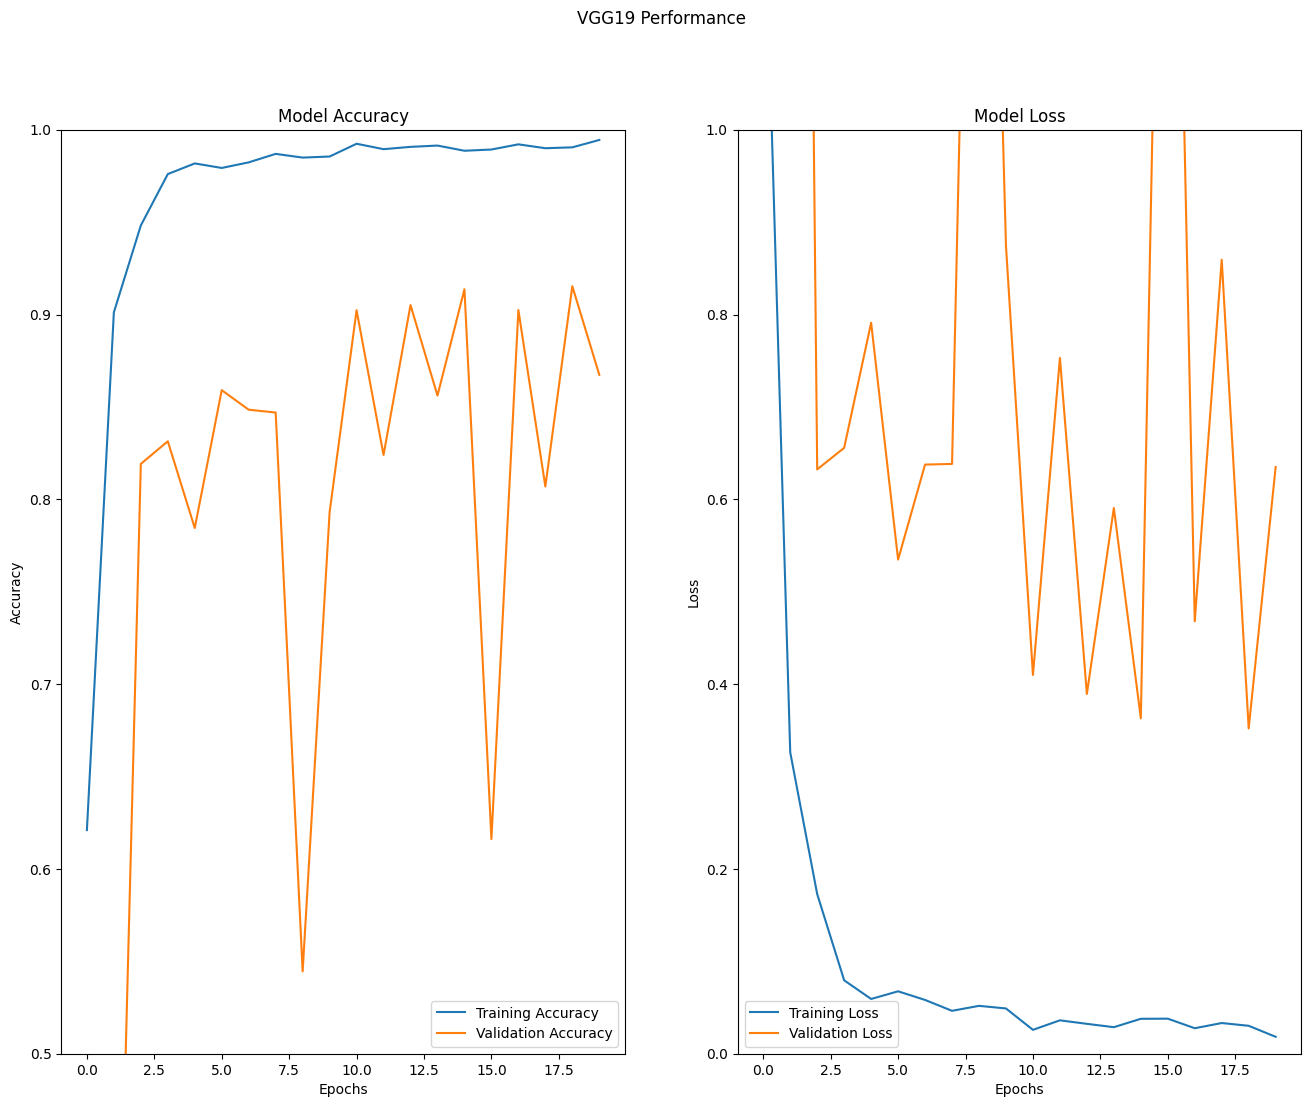

<Figure size 1000x700 with 0 Axes>

In [50]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(resnet_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

In [90]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
savedModel=load_model('ResNet50.keras')
pred = savedModel.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)
print('===========================================================================')
print(classification_report(test_labels, pred))

395/395 [==============================] - 27s 65ms/step
Test Data accuracy:  91.06096595407759
              precision    recall  f1-score   support

           0       0.93      0.42      0.57        60
           1       0.88      0.99      0.93       720
           2       0.88      0.98      0.93       750
           3       0.99      0.77      0.86       450
           4       0.94      0.95      0.95       660
           5       0.93      0.83      0.88       630
           6       0.93      0.89      0.91       150
           7       0.96      0.92      0.94       450
           8       0.97      0.87      0.92       450
           9       0.92      1.00      0.96       480
          10       1.00      0.93      0.96       660
          11       0.76      0.92      0.83       420
          12       0.95      0.99      0.97       690
          13       0.97      1.00      0.98       720
          14       1.00      0.87      0.93       270
          15       0.95      0.99      